## TEXT PREPOCESSING

In [ ]:
!pip install stanza

In [5]:
import stanza
import pickle

In [6]:
with open('dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [7]:
political_data = dataset["politics"]
sport_data = dataset["sport"]
science_data = dataset["scientist"]

In [8]:
print("Number of political documents: ", len(dataset["politics"]))
print("Number of scientific documents: ", len(dataset["scientist"]))
print("Number of sport documents: ", len(dataset["sport"]))
print("Total number of documents: ", len(dataset["politics"]) + len(dataset["scientist"]) + len(dataset["sport"]))

Number of political documents:  96
Number of scientific documents:  136
Number of sport documents:  95
Total number of documents:  327


In [ ]:
stanza.download('en')
nlp = stanza.Pipeline(lang="en", use_gpu=True, processors='tokenize,mwt,pos,lemma')
political_in_docs = [stanza.Document([], text=d.lower()) for d in political_data]
political_out_docs = nlp(political_in_docs)

In [10]:
sport_in_docs = [stanza.Document([], text=d.lower()) for d in sport_data]
sport_out_docs = nlp(sport_in_docs)

In [11]:
science_in_docs = [stanza.Document([], text=d.lower()) for d in science_data]
science_out_docs = nlp(science_in_docs)

In [12]:
processed_dataset = [political_out_docs, science_out_docs, sport_out_docs]

# NAIVE BAYES CLASSIFICATION

In [16]:
def get_pos(data):
  pos_dict = []
  for el in data:
    pos_doc = []
    for word in el.iter_words():
      pos_doc.append(word.xpos)
    pos_dict.append(pos_doc)
  return pos_dict

In [17]:
political_pos = get_pos(political_out_docs)
science_pos = get_pos(science_out_docs)
sport_pos = get_pos(sport_out_docs)

In [18]:
 from sklearn.feature_extraction.text import CountVectorizer

In [19]:
vectorizer = CountVectorizer()
bigrams_vectorizer = CountVectorizer(ngram_range=(2,2))
trigrams_vectorizer = CountVectorizer(ngram_range=(3,3))

pos_corpus = political_pos + science_pos + sport_pos
pos_corpus = [" ".join(el) for el in pos_corpus]
pos_bow = vectorizer.fit_transform(pos_corpus)
bigrams_bow = bigrams_vectorizer.fit_transform(pos_corpus)
trigrams_bow = trigrams_vectorizer.fit_transform(pos_corpus)

## Experiment 1: Naive Bayes with unigram pos tags

In [20]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

clf = MultinomialNB()

X = pos_bow.toarray()
y = np.concatenate((np.zeros(96, dtype=int),np.ones(136, dtype=int),np.full(shape=95,fill_value=2,dtype=np.int)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 99 points : 15


## Experiment 2: Naive Bayes with bigram pos tags

In [21]:
X = bigrams_bow.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 99 points : 9


## Experiment 3: Naive Bayes with trigram pos tags

In [22]:
X = trigrams_bow.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 99 points : 12


# SVM CLASSIFICATION

## features extraction

In [23]:
pos_freq = {}
for docs in processed_dataset: 
  for el in docs:
    for word in el.iter_words():
      if word.pos not in pos_freq:
        pos_freq[word.pos] = 1 
      else:
        pos_freq[word.pos] += 1

pos_freq = sorted(pos_freq.items(), key = lambda x:x[1], reverse=True)

In [24]:
xpos_freq = {}
for docs in processed_dataset: 
  for el in docs:
    for word in el.iter_words():
      if word.xpos not in xpos_freq:
        xpos_freq[word.xpos] = 1 
      else:
        xpos_freq[word.xpos] += 1

xpos_freq = sorted(xpos_freq.items(), key = lambda x:x[1], reverse=True)

In [25]:
functors = ["ADP","AUX","CCONJ","DET","PART","PRON","SCONJ"]
functors_freq = {}
for docs in processed_dataset: 
  for el in docs:
    for word in el.iter_words():
      if word.pos in functors:
        if word.text not in functors_freq:
          functors_freq[word.text] = 1 
        else:
          functors_freq[word.text] += 1

functors_freq = sorted(functors_freq.items(), key = lambda x:x[1], reverse=True)

In [26]:
def get_tokens(data):
  docs = []
  for doc in data:
    tokens = []
    for token in doc.iter_tokens():
      tokens.append(token.text)
    docs.append(tokens)
  return docs

In [27]:
political_tokens = get_tokens(political_out_docs)
science_tokens = get_tokens(science_out_docs)
sport_tokens = get_tokens(sport_out_docs)

In [28]:
def get_ngrams(data,n):
  ngrams = zip(*[data[i:] for i in range(n)])
  return [" ".join(ngram) for ngram in ngrams]

In [29]:
dataset_pos = {}
dataset_pos["politics"] = [(political_tokens[idx], get_ngrams(political_pos[idx],2), get_ngrams(political_pos[idx],3)) for idx in range(len(political_pos))]
dataset_pos["scientist"] = [(science_tokens[idx], get_ngrams(science_pos[idx],2), get_ngrams(science_pos[idx],3)) for idx in range(len(science_pos))]
dataset_pos["sport"] = [(sport_tokens[idx], get_ngrams(sport_pos[idx],2), get_ngrams(sport_pos[idx],3)) for idx in range(len(sport_pos))]

In [30]:
for el in dataset_pos["sport"]:
  if len(el[0]) == 0:
    print("zero found")
    dataset_pos["sport"].remove(el)

zero found


In [31]:
bigram_freq = {}

for docs in dataset_pos.items():
  for el in docs[1]:
    for bigram in el[1]: 
      if bigram not in bigram_freq:
        bigram_freq[bigram] = 1
      else:
        bigram_freq[bigram] += 1

bigram_freq = sorted(bigram_freq.items(), key = lambda x:x[1], reverse=True)

In [32]:
trigram_freq = {}

for docs in dataset_pos.items():
  for el in docs[1]:
    for trigram in el[2]: 
      if trigram not in trigram_freq:
        trigram_freq[trigram] = 1
      else:
        trigram_freq[trigram] += 1

trigram_freq = sorted(trigram_freq.items(), key = lambda x:x[1], reverse=True)

In [33]:
features = []
for el in functors_freq[:405]:
  features.append(el[0])

for el in bigram_freq[:100]:
  features.append(el[0])

for el in trigram_freq[:500]:
  features.append(el[0])

file = open("features.txt", "w")
for el in features:
  file.write(el + "\n")
file.close()

In [34]:
print("Number of features: ", len(features))

Number of features:  1005


## Documents Vector Representation

In [35]:
import pandas as pd

In [36]:
feature_to_idx = {}
for idx,f in enumerate(features):
  feature_to_idx[f] = idx

In [37]:
political_matrix = np.zeros((len(political_out_docs),len(features)))

for idx,tup in enumerate(dataset_pos['politics']):
  for item in tup:
    for el in item:
      if el in feature_to_idx:
        political_matrix[idx,feature_to_idx[el]] += 1
      else:
        continue
  political_matrix[idx] /= len(tup[0])

In [38]:
pd.DataFrame(political_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004
0,0.038089,0.030342,0.029051,0.020013,0.029697,0.032924,0.015494,0.014203,0.006456,0.009684,0.014848,0.009684,0.010329,0.012912,0.002582,0.002582,0.003873,0.007101,0.006456,0.001937,0.005165,0.002582,0.005810,0.001291,0.004519,0.001937,0.003873,0.003873,0.005165,0.004519,0.004519,0.006456,0.003873,0.004519,0.008393,0.001291,0.002582,0.000000,0.000000,0.002582,...,0.000646,0.000000,0.000646,0.000000,0.000000,0.000646,0.000646,0.000000,0.000646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000646,0.000000,0.000646,0.001937,0.000646,0.000000,0.000000,0.000000,0.000000,0.001291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000646,0.000000,0.001937,0.000000,0.001937,0.000000,0.000646,0.000000
1,0.037869,0.035188,0.021783,0.025804,0.008378,0.015751,0.013740,0.015416,0.008043,0.031501,0.005362,0.009383,0.010724,0.007373,0.012735,0.002681,0.002346,0.004357,0.007373,0.005027,0.003351,0.000335,0.001340,0.002011,0.004357,0.002681,0.003351,0.014075,0.007708,0.002681,0.008043,0.005362,0.008043,0.001676,0.006367,0.003351,0.001340,0.003686,0.008713,0.002681,...,0.000335,0.000335,0.000335,0.001340,0.000670,0.000670,0.000335,0.000000,0.000000,0.000000,0.000335,0.000000,0.000670,0.000670,0.001005,0.000000,0.000335,0.000335,0.000000,0.002011,0.001676,0.000670,0.001005,0.000000,0.000335,0.000670,0.000335,0.000335,0.000000,0.000000,0.000000,0.000000,0.001005,0.000335,0.000670,0.001676,0.000670,0.001005,0.000000,0.000335
2,0.033373,0.026222,0.025030,0.014303,0.014303,0.016687,0.000000,0.009535,0.000000,0.070322,0.015495,0.003576,0.004768,0.015495,0.008343,0.000000,0.005959,0.004768,0.009535,0.013111,0.002384,0.000000,0.001192,0.003576,0.003576,0.005959,0.002384,0.020262,0.005959,0.001192,0.003576,0.001192,0.004768,0.009535,0.005959,0.005959,0.000000,0.000000,0.001192,0.008343,...,0.000000,0.001192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001192,0.002384,0.000000,0.000000,0.001192,0.000000,0.001192,0.000000,0.000000,0.002384,0.000000,0.000000,0.001192,0.000000,0.001192,0.001192,0.000000,0.000000,0.000000,0.000000
3,0.052381,0.039683,0.028571,0.039683,0.003175,0.022222,0.001587,0.009524,0.001587,0.017460,0.019048,0.000000,0.011111,0.012698,0.020635,0.001587,0.000000,0.001587,0.003175,0.001587,0.012698,0.006349,0.004762,0.000000,0.001587,0.003175,0.003175,0.022222,0.004762,0.000000,0.004762,0.000000,0.009524,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,...,0.003175,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.000000,0.000000,0.001587,0.000000,0.000000,0.001587,0.003175,0.001587,0.000000,0.000000,0.000000,0.001587,0.001587,0.001587,0.001587,0.000000,0.001587,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.001587,0.000000,0.000000,0.000000
4,0.056511,0.049140,0.034398,0.034398,0.007371,0.014742,0.017199,0.009828,0.014742,0.009828,0.002457,0.000000,0.004914,0.004914,0.004914,0.000000,0.000000,0.002457,0.007371,0.004914,0.012285,0.000000,0.004914,0.000000,0.004914,0.000000,0.004914,0.017199,0.002457,0.000000,0.012285,0.002457,0.004914,0.000000,0.000000,0.000000,0.000000,0.000000,0.012285,0.000000,...,0.000000,0.000000,0.004914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009828,0.000000,0.000000,0.002457,0.000000,0.000000,0.000000,0.000000,0.000000,0.007371,0.000000,0.002457,0.000000,0.000000,0.000000,0.000000,0.002457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002457,0.000000,0.000000,0.000000,0.002457,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [39]:
science_matrix = np.zeros((len(science_out_docs),len(features)))

for idx,tup in enumerate(dataset_pos['scientist']):
  for item in tup:
    for el in item:
      if el in feature_to_idx:
        science_matrix[idx,feature_to_idx[el]] += 1
      else:
        continue
  science_matrix[idx] /= len(tup[0])

In [40]:
pd.DataFrame(science_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004
0,0.042316,0.027283,0.021158,0.030067,0.010022,0.023942,0.0,0.023942,0.0,0.000000,0.000000,0.0,0.006682,0.004454,0.004454,0.003898,0.0,0.005011,0.003898,0.001670,0.005011,0.000000,0.002227,0.0,0.007795,0.000000,0.007795,0.000000,0.003341,0.002784,0.000000,0.000557,0.002227,0.005568,0.001670,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.001114,0.000557,0.002227,0.000557,0.000557,0.0,0.000000,0.0,0.000000,0.000557,0.000000,0.0,0.000557,0.000000,0.001114,0.001114,0.002227,0.000557,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000557,0.00000,0.000000,0.002227,0.000000,0.0,0.0,0.000000,0.0
1,0.046647,0.023810,0.016521,0.041788,0.014091,0.022838,0.0,0.026239,0.0,0.000486,0.002430,0.0,0.008746,0.008260,0.008746,0.006803,0.0,0.005345,0.003401,0.003887,0.004373,0.000000,0.001458,0.0,0.007775,0.000000,0.006803,0.000000,0.001458,0.001458,0.000486,0.000486,0.002915,0.004373,0.003887,0.0,0.000486,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000972,0.000000,0.000972,0.000972,0.000972,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.001944,0.000486,0.000972,0.001944,0.002915,0.000486,0.000000,0.000486,0.0,0.000000,0.0,0.000000,0.0,0.001458,0.00000,0.000486,0.000486,0.000486,0.0,0.0,0.000000,0.0
2,0.039395,0.025653,0.018781,0.027485,0.014201,0.017407,0.0,0.022904,0.0,0.000000,0.002290,0.0,0.008246,0.004581,0.005497,0.003207,0.0,0.008246,0.003207,0.005955,0.006871,0.000458,0.000458,0.0,0.006413,0.000000,0.007329,0.000000,0.004123,0.002290,0.000000,0.000458,0.003207,0.004123,0.004123,0.0,0.001374,0.0,0.0,0.000916,...,0.000000,0.0,0.000000,0.0,0.000916,0.0,0.000916,0.000000,0.002290,0.000916,0.000000,0.0,0.000458,0.0,0.001374,0.000000,0.000000,0.0,0.000000,0.000458,0.000916,0.001374,0.001832,0.001832,0.000458,0.001374,0.0,0.000000,0.0,0.000000,0.0,0.000458,0.00000,0.000000,0.000458,0.000458,0.0,0.0,0.000000,0.0
3,0.045387,0.021214,0.024667,0.030587,0.015787,0.018254,0.0,0.027134,0.0,0.000000,0.001480,0.0,0.007400,0.009867,0.004933,0.003453,0.0,0.008880,0.004933,0.001973,0.003947,0.000000,0.000987,0.0,0.005920,0.000000,0.007893,0.000493,0.000493,0.004440,0.000493,0.000000,0.005427,0.005427,0.003947,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.001973,0.000000,0.000000,0.0,0.000987,0.0,0.000000,0.000000,0.000000,0.0,0.001480,0.000493,0.000987,0.000987,0.001973,0.000987,0.000493,0.000493,0.0,0.000000,0.0,0.000000,0.0,0.000493,0.00000,0.000493,0.000493,0.000987,0.0,0.0,0.000000,0.0
4,0.043606,0.025928,0.020625,0.031821,0.017089,0.017678,0.0,0.023571,0.0,0.000589,0.001768,0.0,0.010018,0.008839,0.004714,0.005303,0.0,0.007661,0.002946,0.001179,0.004125,0.000589,0.001768,0.0,0.004125,0.000000,0.004714,0.001179,0.001179,0.001179,0.001179,0.000000,0.007661,0.007071,0.002946,0.0,0.001768,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000589,0.0,0.001179,0.000000,0.001768,0.000000,0.000000,0.0,0.001179,0.0,0.000589,0.000000,0.000000,0.0,0.001768,0.000000,0.000589,0.000000,0.001768,0.000589,0.000589,0.000589,0.0,0.000589,0.0,0.000000,0.0,0.001179,0.00000,0.000000,0.000589,0.000589,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.048432,0.027675,0.018450,0.036900,0.016144,0.020756,0.0,0.022140,0.0,0.000000,0.003229,0.0,0.005535,0.006458,0.007380,0.000923,0.0,0.005535,0.002768,0.002306,0.003229,0.000000,0.004613,0.0,0.003229,0.000000,0.005996,0.000923,0.001384,0.003690,0.000000,0.000000,

In [41]:
sport_matrix = np.zeros((len(sport_out_docs),len(features)))

for idx,tup in enumerate(dataset_pos['sport']):
  for item in tup:
    for el in item:
      if el in feature_to_idx:
        sport_matrix[idx,feature_to_idx[el]] += 1
      else:
        continue
  sport_matrix[idx] /= len(tup[0])

In [42]:
pd.DataFrame(sport_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004
0,0.032146,0.029625,0.036243,0.013552,0.021746,0.014812,0.049795,0.009770,0.002206,0.016703,0.017334,0.011031,0.006934,0.006934,0.012291,0.006303,0.011346,0.007564,0.005673,0.011031,0.003467,0.001891,0.010400,0.002206,0.001891,0.006303,0.000945,0.000630,0.007564,0.005988,0.007564,0.003782,0.002521,0.001891,0.001891,0.011346,0.001891,0.006934,0.012291,0.000315,...,0.000945,0.000315,0.000315,0.000630,0.000315,0.002206,0.000315,0.000000,0.000000,0.000315,0.000315,0.000000,0.000630,0.000630,0.000000,0.000945,0.000000,0.000000,0.000000,0.000630,0.000000,0.000000,0.0,0.000315,0.000000,0.000000,0.000000,0.000000,0.000000,0.001261,0.001261,0.000000,0.000315,0.000315,0.000000,0.000945,0.000315,0.000315,0.000000,0.000000
1,0.040748,0.026052,0.028724,0.022044,0.010020,0.021376,0.026720,0.010688,0.016700,0.002672,0.008016,0.005344,0.011356,0.009352,0.004008,0.003340,0.003340,0.004676,0.002004,0.002672,0.001336,0.003340,0.007348,0.002672,0.002004,0.005344,0.002004,0.004676,0.004008,0.004676,0.004008,0.002004,0.002672,0.006012,0.001336,0.002672,0.002004,0.011356,0.013360,0.000668,...,0.002004,0.000000,0.003340,0.000668,0.000668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000668,0.000000,0.001336,0.000668,0.000000,0.000000,0.000668,0.000000,0.000000,0.000668,0.001336,0.000000,0.0,0.001336,0.000000,0.000000,0.000000,0.000668,0.000000,0.000668,0.000668,0.001336,0.000000,0.000000,0.000668,0.000668,0.002004,0.000000,0.000668,0.001336
2,0.038857,0.033143,0.029143,0.016000,0.006857,0.021143,0.020000,0.013143,0.013143,0.008571,0.009143,0.009143,0.005714,0.006857,0.006286,0.004000,0.004571,0.005714,0.003429,0.004571,0.008571,0.004571,0.003429,0.001714,0.001714,0.000000,0.002857,0.006857,0.002286,0.004571,0.002857,0.002286,0.008571,0.002857,0.001714,0.001714,0.003429,0.010286,0.016000,0.001714,...,0.003429,0.000000,0.001714,0.000000,0.000000,0.000000,0.000571,0.001143,0.000000,0.000000,0.000000,0.000000,0.002857,0.001143,0.000000,0.000000,0.000571,0.000000,0.000000,0.000571,0.000571,0.001143,0.0,0.000000,0.000571,0.000571,0.001143,0.000571,0.000000,0.000571,0.001714,0.000000,0.000571,0.000000,0.000000,0.000000,0.001143,0.000000,0.000000,0.000000
3,0.021056,0.014989,0.028194,0.011777,0.021413,0.015703,0.056388,0.008565,0.019986,0.005353,0.013562,0.022127,0.009636,0.005710,0.010707,0.002141,0.009993,0.001071,0.006067,0.006424,0.006781,0.002855,0.007495,0.003926,0.000714,0.004283,0.001071,0.000714,0.004640,0.004283,0.002855,0.010350,0.002141,0.000357,0.001428,0.001784,0.002855,0.009279,0.013205,0.003212,...,0.000357,0.000357,0.000357,0.000000,0.000357,0.000000,0.000000,0.000000,0.000714,0.000357,0.000357,0.000000,0.000000,0.000357,0.000000,0.001071,0.000357,0.000714,0.000357,0.000357,0.000000,0.000000,0.0,0.000357,0.000000,0.000000,0.000714,0.000000,0.000000,0.001428,0.000000,0.000000,0.000000,0.000357,0.000357,0.000357,0.000357,0.000714,0.000357,0.000357
4,0.048389,0.027401,0.035855,0.023174,0.035272,0.012535,0.013701,0.014867,0.002332,0.039936,0.014575,0.013992,0.007725,0.012243,0.006996,0.006996,0.012097,0.007142,0.009911,0.008745,0.002041,0.006122,0.005101,0.005393,0.005101,0.005247,0.001895,0.004081,0.004227,0.003498,0.004518,0.007433,0.001895,0.001458,0.002769,0.005247,0.002624,0.000292,0.000292,0.002624,...,0.000729,0.000437,0.000292,0.000000,0.000146,0.000729,0.000437,0.001020,0.000000,0.000583,0.000875,0.000000,0.000146,0.000146,0.000292,0.000437,0.000729,0.000729,0.000292,0.000000,0.000437,0.000292,0.0,0.000292,0.000292,0.000437,0.000437,0.000146,0.000146,0.000146,0.001166,0.000292,0.000292,0.000437,0.000583,0.000583,0.000000,0.000000,0.000292,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Dimensionality reduction

In [43]:
from sklearn.decomposition import PCA

NCOMPONENTS = 64

pca = PCA(n_components=NCOMPONENTS)
pca_pol = pca.fit_transform(political_matrix)
pca_science = pca.fit_transform(science_matrix)
pca_sport = pca.fit_transform(sport_matrix)

In [44]:
pca_pol.shape

(96, 64)

In [45]:
pca_science.shape

(136, 64)

In [46]:
pca_sport.shape

(95, 64)

## Model

In [47]:
from sklearn import svm
from sklearn import metrics

In [48]:
final_dataset = {"featuers_name" : features, 
                 "target_names" : ["politician", "scientist","sport"]}

data = np.concatenate((pca_pol,pca_science,pca_sport))
final_dataset["data"] = data
target = np.concatenate((np.zeros(96, dtype=int),np.ones(136, dtype=int),np.full(shape=95,fill_value=2,dtype=np.int)))
final_dataset["target"] = target

In [50]:
X_train, X_test, y_train, y_test = train_test_split(final_dataset["data"], final_dataset["target"], test_size=0.3)

In [51]:
#Create a svm Classifier
clf = svm.SVC(decision_function_shape='ovr',break_ties=True) # Linear Kernel
 
#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [52]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 72, 1: 89, 2: 67}

In [53]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 24, 1: 47, 2: 28}

In [54]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:",metrics.f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.7171717171717171
Precision: 0.7176255306690089
Recall: 0.7171717171717171
F1-Score: 0.6976688558062046


<Figure size 432x288 with 0 Axes>

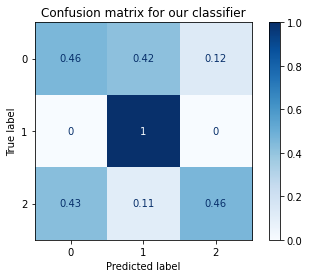

In [55]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig = plt.figure()
# Generate confusion matrix
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.savefig("confusion_matrix.png", dpi=199)
plt.show(matrix)
plt.show()